In [1]:
from retrievalAugmentedTransformer import RAT, Data_Processing

/Users/dipalshah/Desktop/bitsdatathon/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No sentence-transformers model found with name ProsusAI/finbert. Creating a new one with mean pooling.


In [2]:
dp = Data_Processing()
df = dp.get_data("AAPL", "2020-01-01", "2025-04-02")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  13 of 13 completed


In [3]:
print(df.shape)
df = dp.preprocess_features(df)
print(df.shape)

(1319, 22)
(1319, 7)


In [4]:
rat = RAT("AAPL", len(df.columns))
X, y = dp.format_data_combined(df, rat, 10, 5)

In [5]:
rat.query_articles("AAPL")

tensor([[ 0.1499,  0.1358,  0.0778,  ..., -0.2751,  0.0315,  0.0050],
        [ 0.0973,  0.0139,  0.2869,  ..., -0.5628,  0.0362,  0.0250],
        [ 0.0685,  0.0960,  0.2182,  ..., -0.1976, -0.0740,  0.0978],
        [ 0.0692,  0.2341,  0.1467,  ..., -0.2626, -0.0088,  0.0845],
        [ 0.1811, -0.0029,  0.4016,  ..., -0.5056,  0.1019, -0.0202]])

In [6]:
rat.train_model(X, y, epochs = 100)

/Users/dipalshah/Desktop/bitsdatathon/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


RuntimeError: shape '[32, 5, 2]' is invalid for input of size 64

In [ ]:
scale_preds, preds = rat.predict(X[-20:])

In [ ]:
print(X[-20:].shape)
scale_preds.shape

torch.Size([20, 10, 8])


torch.Size([20, 5, 2])

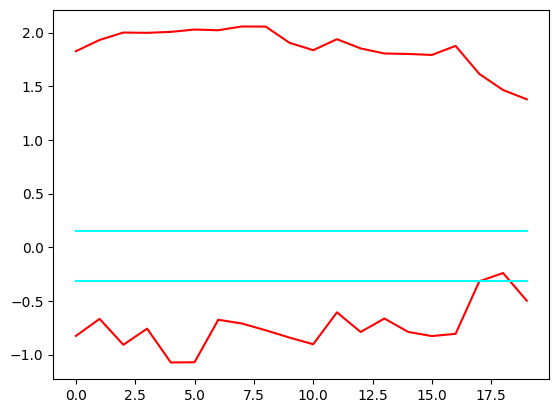

In [ ]:
import matplotlib.pyplot as plt
plt.plot(X[-20:, 0, :2], color = "red")
plt.plot(scale_preds[:, 0], color = "cyan")

In [ ]:
import torch
torch.save(rat.state_dict(), "saved_models/rat.pth")

In [ ]:
import pandas as pd
import requests

def fetch_macro_data():
    # FRED series IDs for macroeconomic indicators
    series_ids = {
        "Fed_Funds_Rate": "FEDFUNDS",
        "CPI": "CPIAUCSL",
        "GDP": "GDPC1",
        "Unemployment_Rate": "UNRATE",
        "Money_Supply": "M2SL",
        "Retail_Sales": "RSXFS",
        "Oil_Price": "IR14250"
    }

    base_url = "https://api.stlouisfed.org/fred/series/observations"
    macro_data = pd.DataFrame()

    # Get the full range of dates you need (e.g., from 2000-01-01 to the most recent available date)
    date_range = pd.date_range(start="2000-01-01", end=pd.to_datetime('today'))

    for column, series_id in series_ids.items():
        # Construct the URL and parameters
        params = {
            "api_key": "d2a5f8b122ea6046576eb67cd258404f",  # Replace with your actual API key
            "file_type": "json",
            "series_id": series_id,
            "observation_start": "2000-01-01",
        }

        # Fetch the data
        response = requests.get(base_url, params=params)
        data = response.json()

        # Parse and format the response data
        observations = data.get("observations", [])
        df = pd.DataFrame(observations)
        df["date"] = pd.to_datetime(df["date"])
        df.set_index("date", inplace=True)
        df["value"] = pd.to_numeric(df["value"], errors="coerce")

        # Create a DataFrame with all the dates in the date range
        full_df = pd.DataFrame(index=date_range)

        # Merge the fetched data with the full date range
        full_df = full_df.merge(df["value"], how="left", left_index=True, right_index=True)
        
        # Forward fill missing data
        full_df["value"] = full_df["value"].ffill()

        # Add the data to the macro_data DataFrame
        macro_data[column] = full_df["value"]

    # Return the final DataFrame with all macroeconomic indicators
    return macro_data

# Example usage:
macro_data = fetch_macro_data()
#macro_data.to_csv("../data/new_macro_data.csv", index = True)